# Customer Churn Prediction Model Training

This notebook contains:
1. Exploratory Data Analysis (EDA)
2. Data Preprocessing
3. Model Training (Random Forest / XGBoost / LightGBM)
4. Model Evaluation
5. Feature Importance Analysis

## Dataset
Telco Customer Churn Dataset from Kaggle: https://www.kaggle.com/datasets/blastchar/telco-customer-churn



In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb
import lightgbm as lgb
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")



Matplotlib is building the font cache; this may take a moment.


Libraries imported successfully!


## Step 1: Load the Dataset

**Note:** Download the dataset from Kaggle and place `WA_Fn-UseC_-Telco-Customer-Churn.csv` in the same directory as this notebook.



In [3]:
# Load the dataset
try:
    df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
    print(f"Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"\nFirst few rows:")
    df.head()
except FileNotFoundError:
    print("ERROR: Dataset file not found!")
    print("Please download 'WA_Fn-UseC_-Telco-Customer-Churn.csv' from:")
    print("https://www.kaggle.com/datasets/blastchar/telco-customer-churn")
    print("\nPlace it in the same directory as this notebook.")



Dataset loaded successfully!
Shape: (7043, 21)

First few rows:


## Step 2: Exploratory Data Analysis (EDA)



In [4]:
# Basic information about the dataset
print("Dataset Info:")
print("=" * 50)
df.info()
print("\n" + "=" * 50)
print("\nMissing Values:")
print(df.isnull().sum())
print("\n" + "=" * 50)
print("\nDataset Statistics:")
df.describe()



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-n

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


Churn Distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn Rate: 26.54%


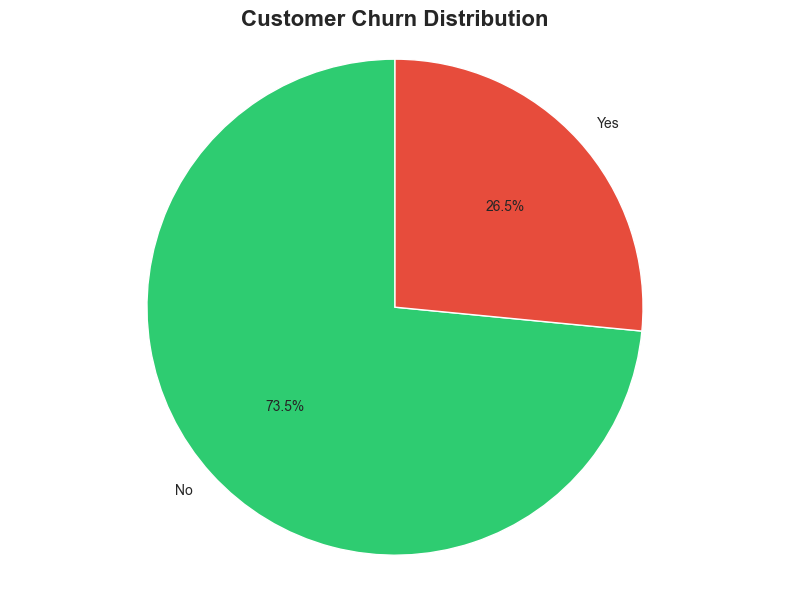

In [5]:
# Check target variable distribution
print("Churn Distribution:")
print(df['Churn'].value_counts())
print(f"\nChurn Rate: {(df['Churn'] == 'Yes').sum() / len(df) * 100:.2f}%")

# Visualization 1: Churn Distribution
plt.figure(figsize=(8, 6))
churn_counts = df['Churn'].value_counts()
colors = ['#2ecc71', '#e74c3c']
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Customer Churn Distribution', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()



<Figure size 1000x600 with 0 Axes>

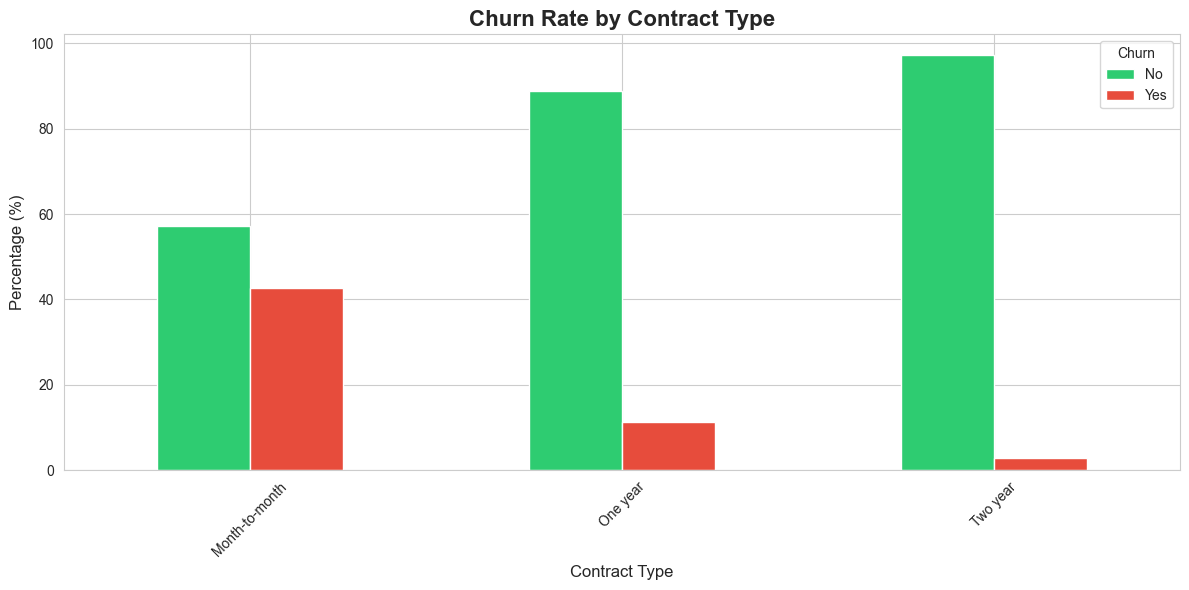

In [6]:
# Visualization 2: Churn by Contract Type
plt.figure(figsize=(10, 6))
contract_churn = pd.crosstab(df['Contract'], df['Churn'])
contract_churn_pct = contract_churn.div(contract_churn.sum(axis=1), axis=0) * 100
contract_churn_pct.plot(kind='bar', color=['#2ecc71', '#e74c3c'])
plt.title('Churn Rate by Contract Type', fontsize=16, fontweight='bold')
plt.xlabel('Contract Type', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



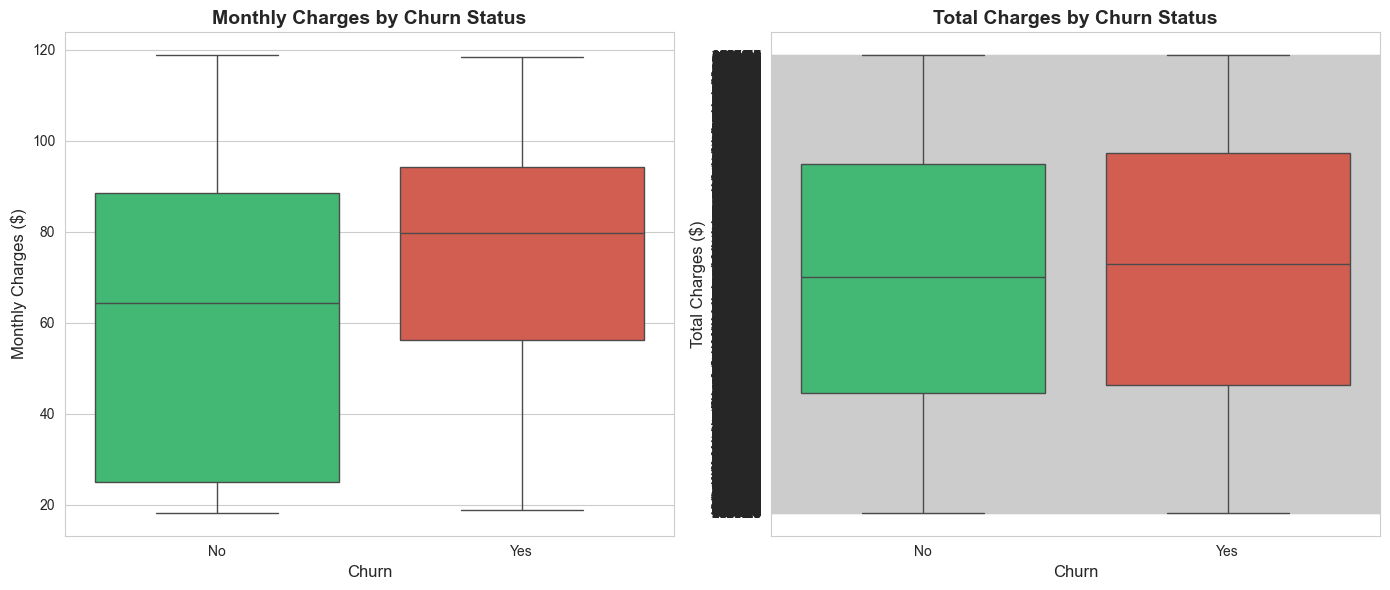

In [7]:
# Visualization 3: Monthly Charges vs Total Charges by Churn
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Monthly Charges distribution
sns.boxplot(data=df, x='Churn', y='MonthlyCharges', ax=axes[0], palette=['#2ecc71', '#e74c3c'])
axes[0].set_title('Monthly Charges by Churn Status', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Churn', fontsize=12)
axes[0].set_ylabel('Monthly Charges ($)', fontsize=12)

# Total Charges distribution
sns.boxplot(data=df, x='Churn', y='TotalCharges', ax=axes[1], palette=['#2ecc71', '#e74c3c'])
axes[1].set_title('Total Charges by Churn Status', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Churn', fontsize=12)
axes[1].set_ylabel('Total Charges ($)', fontsize=12)

plt.tight_layout()
plt.show()



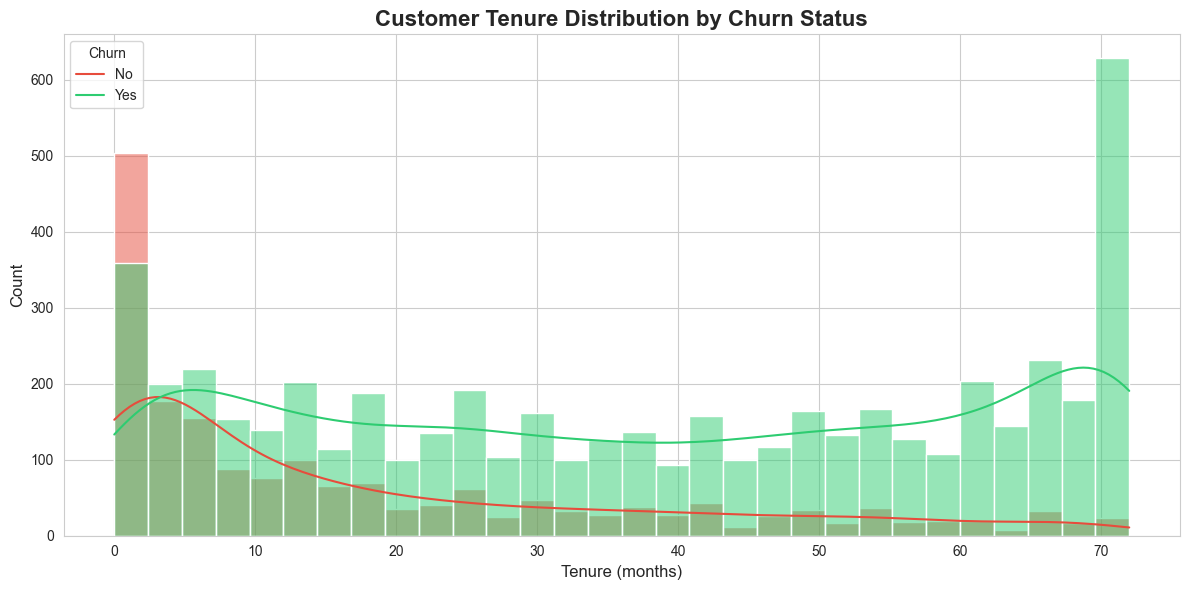

In [8]:
# Visualization 4: Tenure Distribution by Churn
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='tenure', hue='Churn', bins=30, kde=True, palette=['#2ecc71', '#e74c3c'])
plt.title('Customer Tenure Distribution by Churn Status', fontsize=16, fontweight='bold')
plt.xlabel('Tenure (months)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()



## Step 3: Data Preprocessing



In [9]:
# Create a copy for preprocessing
df_processed = df.copy()

# Handle TotalCharges - it's stored as string, convert to numeric
# Some values might be empty strings, replace with 0 or median
df_processed['TotalCharges'] = pd.to_numeric(df_processed['TotalCharges'], errors='coerce')
df_processed['TotalCharges'].fillna(df_processed['TotalCharges'].median(), inplace=True)

# Drop customerID as it's not useful for prediction
df_processed = df_processed.drop('customerID', axis=1)

print("Preprocessing steps completed!")
print(f"Shape after preprocessing: {df_processed.shape}")



Preprocessing steps completed!
Shape after preprocessing: (7043, 20)


In [10]:
# Encode categorical variables
label_encoders = {}
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()

# Remove 'Churn' from categorical columns as it's our target
categorical_cols.remove('Churn')

for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le

# Encode target variable
target_encoder = LabelEncoder()
df_processed['Churn'] = target_encoder.fit_transform(df_processed['Churn'])

print("Categorical encoding completed!")
print(f"Encoded columns: {categorical_cols}")



Categorical encoding completed!
Encoded columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [ ]:
# Prepare features and target
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining set churn rate: {y_train.mean()*100:.2f}%")
print(f"Test set churn rate: {y_test.mean()*100:.2f}%")



Training set size: (5634, 19)
Test set size: (1409, 19)

Training set churn rate: 26.54%
Test set churn rate: 26.54%


## Step 4: Model Training

We'll train multiple models and select the best one:
1. Random Forest
2. XGBoost
3. LightGBM



In [13]:
# Train Random Forest
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_split=5)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

print(f"Random Forest Accuracy: {rf_accuracy*100:.2f}%")
print(f"Random Forest AUC: {rf_auc:.4f}")



Training Random Forest Classifier...
Random Forest Accuracy: 79.84%
Random Forest AUC: 0.8366


In [14]:
# Train XGBoost
print("Training XGBoost Classifier...")
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, max_depth=6, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

print(f"XGBoost Accuracy: {xgb_accuracy*100:.2f}%")
print(f"XGBoost AUC: {xgb_auc:.4f}")



Training XGBoost Classifier...
XGBoost Accuracy: 79.42%
XGBoost AUC: 0.8337


In [16]:
# Train LightGBM
print("Training LightGBM Classifier...")
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42, max_depth=6, learning_rate=0.1, verbose=-1)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)
lgb_accuracy = accuracy_score(y_test, lgb_pred)
lgb_auc = roc_auc_score(y_test, lgb_model.predict_proba(X_test)[:, 1])

print(f"LightGBM Accuracy: {lgb_accuracy*100:.2f}%")
print(f"LightGBM AUC: {lgb_auc:.4f}")



Training LightGBM Classifier...
LightGBM Accuracy: 79.42%
LightGBM AUC: 0.8329


In [18]:
# Compare models and select the best one
models_comparison = {
    'Random Forest': {'accuracy': rf_accuracy, 'auc': rf_auc, 'model': rf_model},
    'XGBoost': {'accuracy': xgb_accuracy, 'auc': xgb_auc, 'model': xgb_model},
    'LightGBM': {'accuracy': lgb_accuracy, 'auc': lgb_auc, 'model': lgb_model}
}

best_model_name = max(models_comparison, key=lambda x: models_comparison[x]['accuracy'])
best_model = models_comparison[best_model_name]['model']

print("=" * 50)
print("MODEL COMPARISON")
print("=" * 50)
for name, metrics in models_comparison.items():
    print(f"{name}:")
    print(f"  Accuracy: {metrics['accuracy']*100:.2f}%")
    print(f"  AUC: {metrics['auc']:.4f}")
    print()

print(f"Best Model: {best_model_name} (Accuracy: {models_comparison[best_model_name]['accuracy']*100:.2f}%)")
print("=" * 50)



MODEL COMPARISON
Random Forest:
  Accuracy: 79.84%
  AUC: 0.8366

XGBoost:
  Accuracy: 79.42%
  AUC: 0.8337

LightGBM:
  Accuracy: 79.42%
  AUC: 0.8329

Best Model: Random Forest (Accuracy: 79.84%)


## Step 5: Model Evaluation



Classification Report for Random Forest:
              precision    recall  f1-score   support

    No Churn       0.84      0.90      0.87      1035
       Churn       0.65      0.51      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



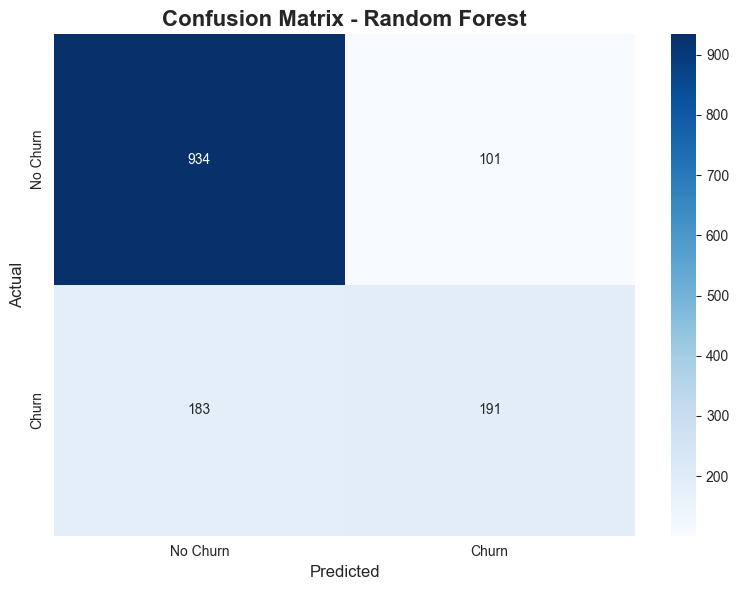

In [19]:
# Detailed evaluation of the best model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print(f"Classification Report for {best_model_name}:")
print("=" * 50)
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))
print("=" * 50)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()



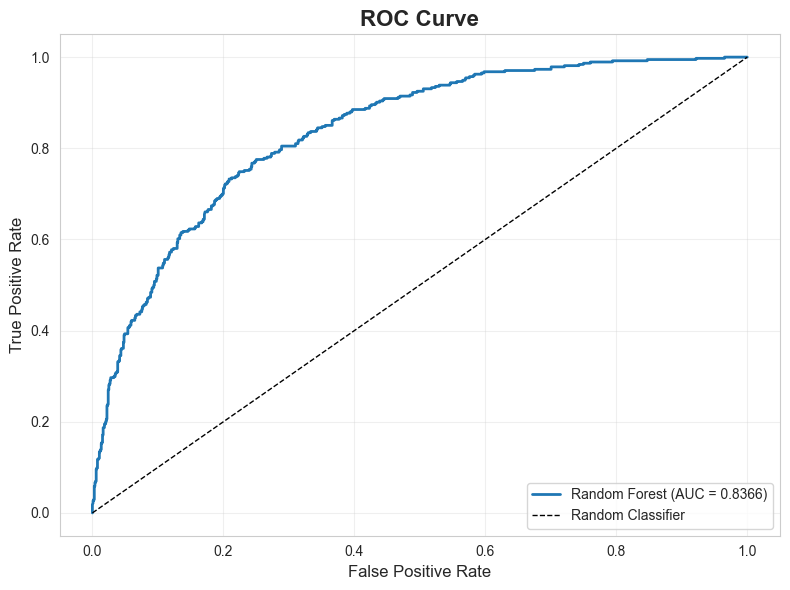

In [20]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'{best_model_name} (AUC = {roc_auc_score(y_test, y_pred_proba):.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=16, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



## Step 6: Feature Importance



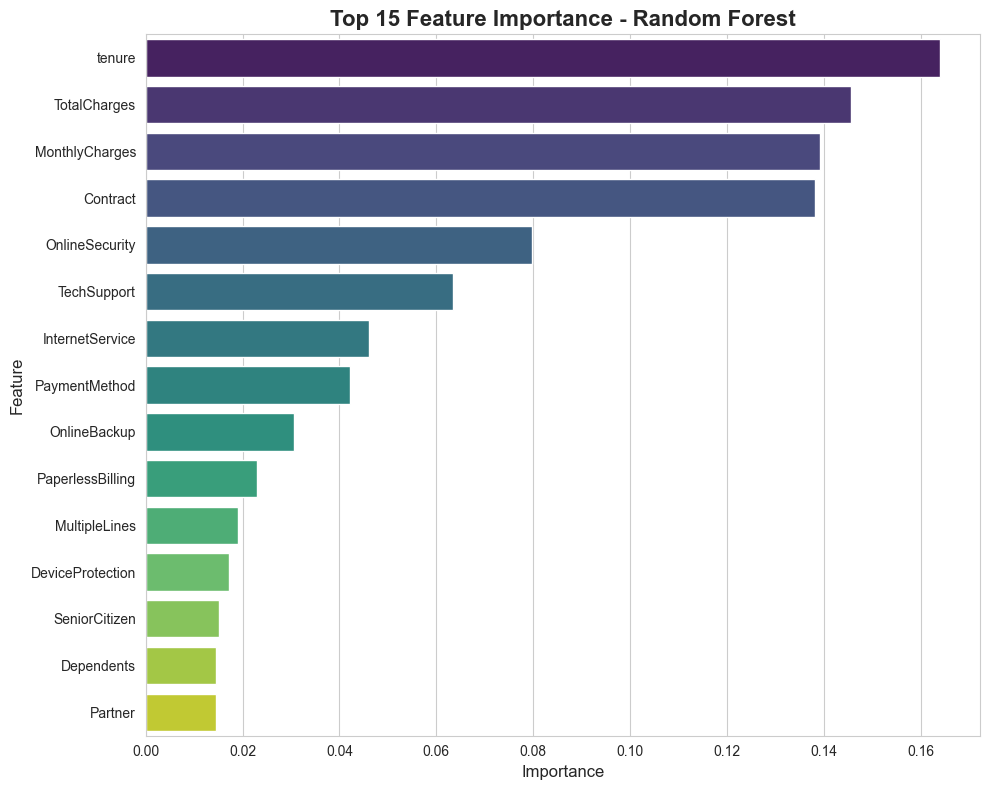

Top 10 Most Important Features:
             feature  importance
4             tenure    0.164024
18      TotalCharges    0.145560
17    MonthlyCharges    0.139282
14          Contract    0.138150
8     OnlineSecurity    0.079685
11       TechSupport    0.063498
7    InternetService    0.046126
16     PaymentMethod    0.042229
9       OnlineBackup    0.030660
15  PaperlessBilling    0.023005


In [21]:
# Get feature importance
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
    plt.title(f'Top 15 Feature Importance - {best_model_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

    print("Top 10 Most Important Features:")
    print(feature_importance.head(10))
elif hasattr(best_model, 'coef_'):
    # For models with coefficients (like logistic regression)
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': np.abs(best_model.coef_[0])
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
    plt.title(f'Top 15 Feature Importance - {best_model_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()



## Step 7: Save the Model



In [22]:
# Save the best model
model_filename = 'churn_model.pkl'
joblib.dump(best_model, model_filename)
print(f"Model saved as {model_filename}")

# Also save the label encoders and feature names for preprocessing in the Streamlit app
import pickle

preprocessing_data = {
    'label_encoders': label_encoders,
    'target_encoder': target_encoder,
    'feature_names': list(X.columns),
    'model_name': best_model_name
}

with open('preprocessing.pkl', 'wb') as f:
    pickle.dump(preprocessing_data, f)

print("Preprocessing data saved as preprocessing.pkl")
print(f"\nFinal Model Performance:")
print(f"  Model: {best_model_name}")
print(f"  Accuracy: {models_comparison[best_model_name]['accuracy']*100:.2f}%")
print(f"  AUC: {models_comparison[best_model_name]['auc']:.4f}")



Model saved as churn_model.pkl
Preprocessing data saved as preprocessing.pkl

Final Model Performance:
  Model: Random Forest
  Accuracy: 79.84%
  AUC: 0.8366
